<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguaje Natural

## Taller #5: TF-IDF
`Fabián Castro`

In [1]:
import re
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
stopwords_sp = stopwords.words('spanish')

from nltk.stem.snowball import SnowballStemmer
spanishStemmer = SnowballStemmer("spanish")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances


pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 20)

In [2]:
DATASET_PATH = '../datasets'
DATASET_NAME = 'bob_esponja.csv'

In [12]:
# some useful functions
def cleanText(text, stemmer, stopwords):
    """
    Takes a string and:
        - converts it to lowercase
        - removes numbers
        - removes special characters
        - removes stop words
        - applies stemming to words
    Finally returns the string after the process
    
    text:str
    stemmer: nltk.stem.snowball.SnowballStemmer
    stopwords: list
    """
    specialCharactersReg = r'[\W\d]'
    
    text = text.lower() # to lowercase
    text = re.sub(specialCharactersReg,' ', text) # removes special characters and numbers
    text = ' '.join([word for word in text.split() if word not in stopwords]) # removes stopwords
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

def findCharacterDistance(matrix, fun):
    """
    To find the coordinates of the items in a matrix according to a function: np.argmax, np.argmin
    """
    return np.unravel_index(fun(matrix, axis = None), matrix.shape)

# Punto 1: Pre-Procesamiento

- `[9 pts]` Leer el archivo `bob_esponja.csv` usando `pandas`
- `[9 pts]` Crear una nueva columna con el texto en minúscula, sin caracteres especiales ni números, sin palabras vacias y hacer stemming de las palabras

In [4]:
# Leer archivo
df = pd.read_csv(os.path.join(DATASET_PATH, DATASET_NAME), sep = ',', header = 0, engine = 'c')
df.head()

,Personaje,Descripción
0,Bob Esponja Pantalones Cuadrados,"Bob Esponja es una esponja de mar con forma rectangular. Es de color amarillo claro con un contorno verde oliva claro. En episodios anteriores, es más ancho cerca de la parte superior y se vuelve ..."
1,Patricio Estrella,"Es una estrella de mar de color rosa, el mejor amigo de Bob Esponja junto con Arenita Mejillas. Usa un bañador verde con dibujos de flores y no usa camisa aunque usa un traje marrón en sus momento..."
2,Calamardo Tentáculos,Calamardo Tentáculos es un personaje principal de Bob Esponja. Calamardo es un pulpo que vive en un moái como casa. Es vecino de Bob Esponja y Patricio Estrella.\nEs amargado y de un carácter pesi...
3,Arenita Mejillas,"Arenita Mejillas (Sandy Cheeks en inglés) en un personaje principal de Bob Esponja. Ella es una ardilla que le gustan los deportes extremos y la ciencia.\n\nSu nombre real es Sandra, aunque es lla..."
4,Eugenio H. Cangrejo,"Don Eugenio H. Cangrejo (normalmente llamado Señor Cangrejo en España o Don Cangrejo en Hispanoamérica) es un personaje principal de la serie de televisión Bob Esponja. Vive en un ancla, austerame..."


In [5]:
# Nueva columna
df['pre-procesado'] = df['Descripción'].apply(lambda text: cleanText(text, spanishStemmer, stopwords_sp))
df.head()

,Personaje,Descripción,pre-procesado
0,Bob Esponja Pantalones Cuadrados,"Bob Esponja es una esponja de mar con forma rectangular. Es de color amarillo claro con un contorno verde oliva claro. En episodios anteriores, es más ancho cerca de la parte superior y se vuelve ...",bob esponj esponj mar form rectangul color amarill clar contorn verd oliv clar episodi anterior ancho cerc part superior vuelv delg haci abaj simil trapeci embarg episodi recient form cuadr regul ...
1,Patricio Estrella,"Es una estrella de mar de color rosa, el mejor amigo de Bob Esponja junto con Arenita Mejillas. Usa un bañador verde con dibujos de flores y no usa camisa aunque usa un traje marrón en sus momento...",estrell mar color ros mejor amig bob esponj junt arenit mejill usa bañador verd dibuj flor usa camis aunqu usa traj marron moment especial dorm rop interior usa gorr verd pal trabaj ningun mascot ...
2,Calamardo Tentáculos,Calamardo Tentáculos es un personaje principal de Bob Esponja. Calamardo es un pulpo que vive en un moái como casa. Es vecino de Bob Esponja y Patricio Estrella.\nEs amargado y de un carácter pesi...,calamard tentacul personaj principal bob esponj calamard pulp viv moai cas vecin bob esponj patrici estrell amarg caract pesim aunqu casi siempr mal humor vec suel comport maner despreci sarcast c...
3,Arenita Mejillas,"Arenita Mejillas (Sandy Cheeks en inglés) en un personaje principal de Bob Esponja. Ella es una ardilla que le gustan los deportes extremos y la ciencia.\n\nSu nombre real es Sandra, aunque es lla...",arenit mejill sandy cheeks ingles personaj principal bob esponj ardill gust deport extrem cienci nombr real sandr aunqu llam sandy amig traduc español arenit originari tex orgull serl siend objet ...
4,Eugenio H. Cangrejo,"Don Eugenio H. Cangrejo (normalmente llamado Señor Cangrejo en España o Don Cangrejo en Hispanoamérica) es un personaje principal de la serie de televisión Bob Esponja. Vive en un ancla, austerame...",don eugeni h cangrej normal llam señor cangrej españ don cangrej hispanoamer personaj principal seri television bob esponj viv ancla auster decor hij ballen perlit novi señor puff nombr complet eu...


# Punto 2: TF-IDF

- `[16 pts]` Crear la matriz TF-IDF

In [6]:
tfidf_vect = TfidfVectorizer()
tfidf_ = tfidf_vect.fit_transform(df['pre-procesado'].values)

tfidf_matrix = pd.DataFrame(np.round(tfidf_.toarray(), 3),
                            index = df['Personaje'].values,
                            columns = tfidf_vect.get_feature_names())

display(tfidf_matrix.T.head(20))
display(tfidf_matrix.T.tail(20))

,Bob Esponja Pantalones Cuadrados,Patricio Estrella,Calamardo Tentáculos,Arenita Mejillas,Eugenio H. Cangrejo,Sheldon J. Plankton,Karen Plankton,Perlita Cangrejo,Sra. Puff,Gary el Caracol
abaj,0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
aborrec,0.000,0.000,0.091,0.000,0.000,0.000,0.000,0.000,0.000,0.000
acab,0.000,0.000,0.091,0.000,0.000,0.000,0.000,0.000,0.000,0.000
accident,0.049,0.000,0.000,0.000,0.045,0.000,0.000,0.000,0.000,0.000
acept,0.000,0.000,0.000,0.000,0.000,0.000,0.064,0.000,0.000,0.000
aconsej,0.000,0.000,0.000,0.000,0.000,0.000,0.064,0.000,0.000,0.000
actu,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.070,0.000,0.000
acuerd,0.000,0.000,0.000,0.000,0.000,0.000,0.064,0.000,0.000,0.000
ademas,0.097,0.000,0.000,0.000,0.000,0.107,0.000,0.000,0.000,0.000
adolescent,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.282,0.000,0.000


,Bob Esponja Pantalones Cuadrados,Patricio Estrella,Calamardo Tentáculos,Arenita Mejillas,Eugenio H. Cangrejo,Sheldon J. Plankton,Karen Plankton,Perlita Cangrejo,Sra. Puff,Gary el Caracol
ven,0.000,0.075,0.00,0.000,0.000,0.000,0.0,0.00,0.000,0.000
vend,0.000,0.000,0.00,0.000,0.053,0.000,0.0,0.00,0.000,0.000
verd,0.097,0.128,0.00,0.000,0.000,0.000,0.0,0.00,0.000,0.000
verdader,0.000,0.064,0.00,0.000,0.045,0.000,0.0,0.00,0.000,0.000
version,0.000,0.000,0.00,0.000,0.000,0.000,0.0,0.07,0.000,0.000
vest,0.000,0.000,0.00,0.000,0.000,0.000,0.0,0.07,0.000,0.000
vez,0.085,0.000,0.00,0.000,0.039,0.094,0.0,0.00,0.000,0.000
vid,0.000,0.000,0.00,0.000,0.000,0.126,0.0,0.00,0.000,0.000
vide,0.057,0.000,0.00,0.000,0.000,0.000,0.0,0.00,0.000,0.000
videojueg,0.000,0.000,0.00,0.000,0.000,0.126,0.0,0.00,0.000,0.000


# Punto 3: Distancia del coseno
- `[12 pts]` Calcular la distancia del coseno entre cada una de los personajes
- `[2 pts]` ¿Cuáles son los personajes más parecidos?
- `[2 pts]` ¿Cuáles son los personajes más diferentes?

In [8]:
dist_cos = cosine_distances(tfidf_matrix.values)
dist_cos = pd.DataFrame(dist_cos, columns = tfidf_matrix.index, index = tfidf_matrix.index)
dist_cos

,Bob Esponja Pantalones Cuadrados,Patricio Estrella,Calamardo Tentáculos,Arenita Mejillas,Eugenio H. Cangrejo,Sheldon J. Plankton,Karen Plankton,Perlita Cangrejo,Sra. Puff,Gary el Caracol
Bob Esponja Pantalones Cuadrados,0.000000,0.826052,0.918644,0.838317,0.868204,0.872076,0.938609,0.885810,0.858077,0.924158
Patricio Estrella,0.826052,0.000000,0.790530,0.841122,0.831634,0.966449,0.930045,0.891502,0.952583,0.894790
Calamardo Tentáculos,0.918644,0.790530,0.000000,0.919857,0.831344,0.917606,0.949913,0.967265,0.968111,0.851644
Arenita Mejillas,0.838317,0.841122,0.919857,0.000000,0.908202,0.967774,0.948323,0.962015,0.972120,0.900641
Eugenio H. Cangrejo,0.868204,0.831634,0.831344,0.908202,0.000000,0.687380,0.891897,0.796723,0.896080,0.920664
Sheldon J. Plankton,0.872076,0.966449,0.917606,0.967774,0.687380,0.000000,0.794981,0.922577,0.986733,0.969239
Karen Plankton,0.938609,0.930045,0.949913,0.948323,0.891897,0.794981,0.000000,0.966088,0.984919,0.965252
Perlita Cangrejo,0.885810,0.891502,0.967265,0.962015,0.796723,0.922577,0.966088,0.000000,0.873832,0.969504
Sra. Puff,0.858077,0.952583,0.968111,0.972120,0.896080,0.986733,0.984919,0.873832,0.000000,0.964177
Gary el Caracol,0.924158,0.894790,0.851644,0.900641,0.920664,0.969239,0.965252,0.969504,0.964177,0.000000


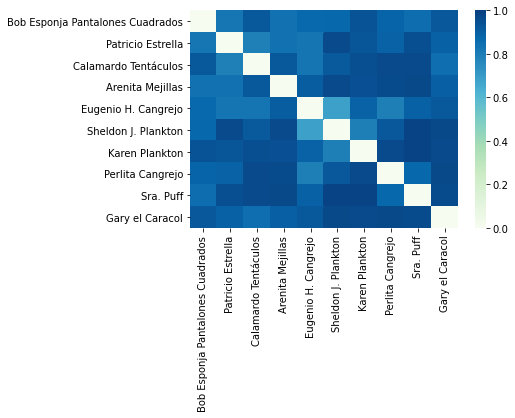

In [9]:
#heatmap
sns.heatmap(dist_cos, vmin = 0, vmax = 1, cmap = plt.get_cmap('GnBu'));

# ¿Cuáles son los personajes más parecidos?

In [10]:
dist_cos_nonzero = np.copy(dist_cos) # to eliminate distances of zero
dist_cos_nonzero[dist_cos_nonzero == 0] = 1
findCharacterDistance(dist_cos_nonzero, np.argmin)

character_1 = dist_cos.index[findCharacterDistance(dist_cos_nonzero, np.argmin)[0]]
character_2 = dist_cos.columns[findCharacterDistance(dist_cos_nonzero, np.argmin)[1]]
print(f'De acuerdo a la distnacia del coseno, los personajes más parecidos (con menor distancia) son: {character_1} y {character_2}')

De acuerdo a la distnacia del coseno, los personajes más parecidos (con menor distancia) son: Eugenio H. Cangrejo y Sheldon J. Plankton


# ¿Cuáles son los personajes más diferentes?

In [11]:
character_1 = dist_cos.index[findCharacterDistance(dist_cos, np.argmax)[0]]
character_2 = dist_cos.columns[findCharacterDistance(dist_cos, np.argmax)[1]]
print(f'De acuerdo a la distancia del coseno, los personajes más distintos (con mayor distancia) son: {character_1} y {character_2}')

De acuerdo a la distancia del coseno, los personajes más distintos (con mayor distancia) son: Sheldon J. Plankton y Sra. Puff
